In [76]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
import torchaudio
from sp4asc.datasets.dcase import DCaseDataset
import librosa
import librosa.display
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sp4asc.models.cnns import LogMelSpectrogram
from sp4asc.training import TrainingManager

%matplotlib inline

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


### Gros Neural Network

In [78]:
%mkdir data
%cd data
!wget 
!tar -zxvf .tgz

[WinError 2] The system cannot find the file specified: 'data'
C:\Users


Access is denied.
'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open '.tgz'


In [79]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is 4297-5642

 Directory of C:\Users

11/10/2021  06:10 PM    <DIR>          .
03/05/2022  04:54 PM    <DIR>          postgres
11/10/2021  06:21 PM    <DIR>          Public
03/05/2022  08:45 PM    <DIR>          saifs
               0 File(s)              0 bytes
               4 Dir(s)  122,045,931,520 bytes free


In [80]:
%cd 
%ls

C:\Users\saifs
 Volume in drive C has no label.
 Volume Serial Number is 4297-5642

 Directory of C:\Users\saifs

03/05/2022  08:45 PM    <DIR>          .
11/10/2021  06:10 PM    <DIR>          ..
04/17/2021  08:50 PM    <DIR>          .cache
01/10/2022  05:54 PM    <DIR>          .conda
04/08/2021  01:32 PM                43 .condarc
12/06/2021  03:16 PM    <DIR>          .config
01/28/2022  02:06 AM    <DIR>          .docker
09/22/2021  12:32 PM    <DIR>          .ebookreader
04/17/2021  08:50 PM    <DIR>          .eclipse
05/06/2021  04:45 PM    <DIR>          .flair
11/10/2021  10:59 PM                60 .gitconfig
10/22/2021  01:46 AM    <DIR>          .idlerc
02/10/2022  01:28 PM    <DIR>          .ipynb_checkpoints
04/08/2021  01:32 PM    <DIR>          .ipython
10/17/2021  08:50 PM    <DIR>          .jupyter
11/13/2021  10:06 PM    <DIR>          .keras
02/11/2022  04:36 PM    <DIR>          .lemminx
01/28/2022  04:55 PM    <DIR>          .m2
04/14/2021  12:56 AM    <DIR>      

#### Data Processing



In [81]:
%cd ..
data_dir = '/data'

C:\Users


### Creating ResNet model

In [82]:
model_resnet = models.resnet50(pretrained=False,progress=True)

In [83]:
model_resnet.fc = torch.nn.Linear(in_features=2048,out_features=10)
model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [84]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Data Extraction

In [85]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is 4297-5642

 Directory of C:\Users

11/10/2021  06:10 PM    <DIR>          .
03/05/2022  04:54 PM    <DIR>          postgres
11/10/2021  06:21 PM    <DIR>          Public
03/05/2022  08:45 PM    <DIR>          saifs
               0 File(s)              0 bytes
               4 Dir(s)  122,045,931,520 bytes free


In [86]:
def get_audio(file):
    signal, sample_rate = librosa.load(file, sr= 22050) 

def draw_signal(signal, sample_rate):
    FIG_SIZE = (15,4)
    plt.figure(figsize=FIG_SIZE)
    librosa.display.waveshow(signal, sample_rate, alpha=0.4)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")

    # FFT -> power spectrum
    # perform Fourier transform
    fft = np.fft.fft(signal)

    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)

    # create frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))

    # take half of the spectrum and frequency
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]

    # plot spectrum
    plt.figure(figsize=FIG_SIZE)
    plt.plot(left_f, left_spectrum, alpha=0.4)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Power spectrum")


In [87]:
import os

root_dir = "C:\Project-Acoustic-Scene-Classification-DCASE\data\TAU-urban-acoustic-scenes-2020-mobile-development"

files = os.listdir(root_dir + '/audio_train')

files = [[file] + file.replace('.wav','').split('-',5) for file in files]
df_files = pd.DataFrame(files,columns=['file_name','label_name','city','location_id','segment_id','device_id'])
df_files.to_csv(root_dir + '/train_data.csv',index=False)

In [88]:
root_dir ="C:\Project-Acoustic-Scene-Classification-DCASE\data\TAU-urban-acoustic-scenes-2020-mobile-development"
files = os.listdir(root_dir + '/audio_test')
files = [[file] + file.replace('.wav','').split('-',5) for file in files]
df_files = pd.DataFrame(files,columns=['file_name','label_name','city','location_id','segment_id','device_id'])
df_files.to_csv(root_dir + '/test_data.csv',index=False)

In [89]:
# dataloader 

class DCaseDataset(Dataset):
    labelind2name = {
        0: "airport",
        1: "bus",
        2: "metro",
        3: "metro_station",
        4: "park",
        5: "public_square",
        6: "shopping_mall",
        7: "street_pedestrian",
        8: "street_traffic",
        9: "tram",
    }
    name2labelind = {
        "airport": 0,
        "bus": 1,
        "metro": 2,
        "metro_station": 3,
        "park": 4,
        "public_square": 5,
        "shopping_mall": 6,
        "street_pedestrian": 7,
        "street_traffic": 8,
        "tram": 9,
    }

    def __init__(self,root_dir,split):
        self.root_dir = root_dir
        self.split = split
        if split== "train":
            csv_path = root_dir + "/train_data.csv"

        elif split == "val":
            csv_path = root_dir + "/val_data.csv"
        elif split == "test":
            csv_path = root_dir + "/test_data.csv"
        else:
            raise ValueError("Split not implemented")

        csvData = pd.read_csv(csv_path, sep=",")
        # In test mode, just get file list
        if split == "test":
            self.file_names = []
            for i in range(0, len(csvData)):
                self.file_names.append(csvData.iloc[i, 0])
            return

        self.file_names, self.labels,self.devices = [], [],[]

        for i in range(0, len(csvData)):
            self.file_names.append(csvData.iloc[i, 0])
            self.labels.append(csvData.iloc[i, 1])
            self.devices.append(csvData.iloc[i,5])

        # Transform class name to index
        self.labels = [self.name2labelind[name] for name in self.labels] 

    def __getitem__(self,index):
       # Load data
        filepath = self.root_dir + '/audio_' + self.split + '/' + self.file_names[index]
        sound, sfreq = torchaudio.load(filepath)
        assert sound.shape[0] == 1, "Expected mono channel"
        sound = torch.mean(sound, dim=0)
        assert sfreq == 44100, "Expected sampling rate of 44.1 kHz"

        # Remove last samples if longer than expected
        if sound.shape[-1] >= 441000:
            sound = sound[:441000]

        if self.split == "test":
            return  sound, 255, self.file_names[index], "unknown"
        else:
            return (
                sound,
                self.labels[index],
                self.file_names[index],
                self.devices[index],
            )
    
    def __len__(self):
        return len(self.file_names)


In [90]:
train_dataset = DCaseDataset(
    root_dir="C:\Project-Acoustic-Scene-Classification-DCASE\data\TAU-urban-acoustic-scenes-2020-mobile-development",
    split = 'train'
)

test_dataset = DCaseDataset(
    root_dir="C:\Project-Acoustic-Scene-Classification-DCASE\data\TAU-urban-acoustic-scenes-2020-mobile-development",
    split = 'test'
)

In [91]:
train_dataset[0]

(tensor([-0.0025, -0.0019, -0.0028,  ...,  0.0013, -0.0006, -0.0007]),
 0,
 'airport-barcelona-0-0-a.wav',
 'a')

<ipython-input-86-f135eac8862f>:7: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sample_rate, alpha=0.4)


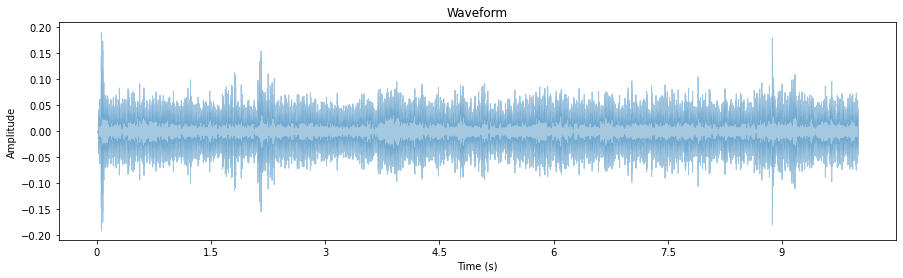

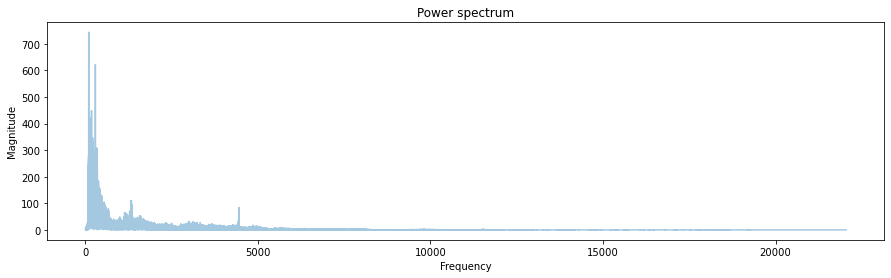

In [92]:
sample_rate = 44100
draw_signal(train_dataset[3][0].numpy(), sample_rate)

In [93]:
import tarfile
import argparse

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        for file in os.listdir(source_dir):
            if file == "data":
                pass
            elif file.split(".")[-1] == "egg-info":
                pass
            else:
                tar.add(os.path.join(source_dir, file))

In [94]:
batchsize = 32
num_workers = 0#1
reload = False
dropout = 0.2
specAugment = [128, 2, 32, 2]
lr = 1e-3
eta_min = 1e-5
max_epoch = 200
weight_decay = 1e-5
mixup_alpha = None
out_dir =  "C:/Project-Acoustic-Scene-Classification-DCASE/data/TAU-urban-acoustic-scenes-2020-mobile-development/trained_models/"

In [95]:
from sp4asc.training import CELoss
from sp4asc.training import MixUp
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

class TrainingManager:
    def __init__(
        self,
        net,
        spectrogram,
        loader_train,
        loader_test,
        optim,
        scheduler,
        max_epoch,
        reload,
        mixup_alpha,
        path_to_ckpt,
        nb_classes=10
    ):

        # Optim. methods
        self.optim = optim
        self.scheduler = scheduler

        # Dataloaders
        self.max_epoch = max_epoch
        self.loader_train = loader_train
        self.loader_test = loader_test

        # Networks
        self.dev = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = net.to(self.dev)
        self.spectrogram = spectrogram.to(self.dev).eval()

        # Mixup and loss
        self.loss = CELoss(nb_classes=nb_classes)
        self.mixup = MixUp(alpha=mixup_alpha, nb_classes=nb_classes)

        # Checkpoints
        self.path_to_ckpt = path_to_ckpt + "/ckpt.pth"
        if reload:
            self.load_state()
        else:
            self.current_epoch = 0

        # Monitoring
        self.writer = SummaryWriter(
            path_to_ckpt + "/tensorboard/",
            purge_step=self.current_epoch + 1,
        )

    def print_log(self, running_loss, nb_it, acc, nb_instances):
        log = (
            "\nEpoch: {0:d} :".format(self.current_epoch)
            + " loss = {0:.3f}".format(running_loss / (nb_it + 1))
            + " - acc1 = {0:.3f}".format(100 * acc / nb_instances)
        )
        print(log)

    def one_epoch(self, training):

        # Train or eval mode
        if training:
            self.net.train()
            self.mixup.train()
            loader = self.loader_train
            print("\nTraining: %d/%d epochs" % (self.current_epoch, self.max_epoch))
        else:
            self.net.eval()
            self.mixup.eval()
            loader = self.loader_test
            print("\nTest:")

        # Stat.
        acc = 0
        nb_instances = 0
        running_loss = 0
        delta = len(loader) // 3

        # Loop over mini-batches
        bar_format = "{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}"
        for it, batch in enumerate(tqdm(loader, bar_format=bar_format)):

            # Data
            sound = batch[0].to(self.dev, non_blocking=True)
            gt_class = batch[1].to(self.dev, non_blocking=True)
           
            # Get network outputs with mixup during training
            with torch.no_grad():
                sound = self.spectrogram(sound)
               
                sound, gt_class = self.mixup(sound, gt_class)
                
                if not training:
                    pred_class = self.net(sound)
            if training:
                self.optim.zero_grad()
                pred_class = self.net(sound)

            # Loss & backprop
            loss_class = self.loss(pred_class, gt_class)
            if training:
                loss_class.backward()
                self.optim.step()

            # Log
            acc += (pred_class.max(1)[1] == gt_class.max(1)[1]).sum()
            nb_instances += gt_class.shape[0]
            running_loss += loss_class.item()
            if it % delta == delta - 1:
                self.print_log(running_loss, it, acc, nb_instances)

        # Print log
        self.print_log(running_loss, it, acc, nb_instances)
        header = "Train" if training else "Test"
        self.writer.add_scalar(
            header + "/loss", running_loss / (it + 1), self.current_epoch + 1
        )
        self.writer.add_scalar(
            header + "/acc", 100 * acc / nb_instances, self.current_epoch + 1
        )

    def load_state(self):
        ckpt = torch.load(self.path_to_ckpt, map_location=torch.device(self.dev))
        self.net.load_state_dict(ckpt["net"])
        self.optim.load_state_dict(ckpt["optim"])
        self.scheduler.load_state_dict(ckpt["scheduler"])
        self.current_epoch = ckpt["epoch"]
        # Check config is the same
        for key in ckpt["config"].keys():
            assert key in self.config.keys()
            if key == "reload":
                pass
            assert (
                self.config[key] == ckpt["config"][key]
            ), "Config file is not compatible with saved one."

    def save_state(self):
        dict_to_save = {
            "epoch": self.current_epoch,
            "net": self.net.state_dict(),
            "optim": self.optim.state_dict(),
            "scheduler": self.scheduler.state_dict(),
            "config": self.config,
        }
        torch.save(dict_to_save, self.path_to_ckpt)

    def train(self):
        for _ in range(self.current_epoch, self.max_epoch):
            self.one_epoch(training=True)
            self.scheduler.step()
            self.one_epoch(training=False)
            self.current_epoch += 1
            self.save_state()
        print("Finished Training")

    def eval(self):
        self.one_epoch(training=False)


In [97]:
"""
# --- Args
parser = argparse.ArgumentParser(description="Training with mixup")

parser.add_argument(
    "--config",
    type=str,
    default="C:/Project-Acoustic-Scene-Classification-DCASE/configs/example.py",
    help="Path to config file describing training parameters",
)

args = parser.parse_args()

# ---
print("Training script: ", os.path.realpath(__file__))

# --- Config
name_config = args.config.replace(".py", "").replace(os.path.sep, ".")
config = __import__(name_config, fromlist=["config"]).config
print("Config parameters:")
print(config)


# --- Log dir
path2log = config["out_dir"] + name_config
os.makedirs(path2log, exist_ok=True)
make_tarfile(path2log + "/src.tgz", os.path.dirname(os.path.realpath(__file__)))

# ---
current_dir = os.path.dirname(os.path.abspath(__file__))
"""
train_dataset = DCaseDataset(
    root_dir="C:/Project-Acoustic-Scene-Classification-DCASE/data/TAU-urban-acoustic-scenes-2020-mobile-development",
    split = 'train'
)

test_dataset = DCaseDataset(
    root_dir="C:/Project-Acoustic-Scene-Classification-DCASE/data/TAU-urban-acoustic-scenes-2020-mobile-development",
    split = 'test'
)

loader_train = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers,
    drop_last=True,
)

loader_test = DataLoader(
    test_dataset,
    batch_size=batchsize,
    shuffle=False,
    pin_memory=True,
    num_workers=num_workers,
    drop_last=False,
)

# --- Get network
spectrogram = LogMelSpectrogram()
net = model_resnet
print("\n\nNet at training time")
print(net)

# ---
optim = torch.optim.AdamW(
    [
        {"params": net.parameters()},
    ],
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim,
    max_epoch,
    eta_min=eta_min
)

# --- Log dir
path2log = out_dir

# --- Training
mng = TrainingManager(
    net,
    spectrogram,
    loader_train,
    loader_test,
    optim,
    scheduler,
    max_epoch,
    reload,
    mixup_alpha,
    path2log
)

print(4)
mng.train()

       0%|                                                  | 0/47 [00:00<?, ?it/s]



Net at training time
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_s

      32%|███████████████▉                                  | 15/47 [09:29<19:08, 35.89s/it]


Epoch: 0 : loss = 0.092 - acc1 = 100.000


      64%|███████████████████████████████▉                  | 30/47 [18:36<10:44, 37.92s/it]


Epoch: 0 : loss = 0.046 - acc1 = 100.000


      96%|███████████████████████████████████████████████▊  | 45/47 [31:06<01:29, 44.84s/it]


Epoch: 0 : loss = 0.031 - acc1 = 100.000


       0%|                                                  | 0/48 [00:00<?, ?it/s]


Epoch: 0 : loss = 0.029 - acc1 = 100.000

Test:


       0%|                                                  | 0/48 [00:02<?, ?it/s]


RuntimeError: Class values must be smaller than num_classes.

## Lottery ticket hypothesis



In [104]:
import utils

In [105]:
model = model_resnet

NameError: name 'init' is not defined

In [106]:
 # Weight Initialization
model.apply(weight_init)

NameError: name 'init' is not defined

In [107]:
 # Copying and Saving Initial State
initial_state_dict = copy.deepcopy(model.state_dict())
utils.checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
torch.save(model, f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/initial_state_dict_{args.prune_type}.pth.tar")

NameError: name 'copy' is not defined

In [109]:
# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss() # Default was F.nll_loss

In [110]:
# Layer Looper
for name, param in model.named_parameters():
    print(name, param.size())

conv1.weight torch.Size([64, 1, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [ ]:
# Function for Training
def train(model, train_loader, optimizer, criterion):
    EPS = 1e-6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (imgs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        #imgs, targets = next(train_loader)
        imgs, targets = imgs.to(device), targets.to(device)
        output = model(imgs)
        train_loss = criterion(output, targets)
        train_loss.backward()

        # Freezing Pruned weights by making their gradients Zero
        for name, p in model.named_parameters():
            if 'weight' in name:
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                p.grad.data = torch.from_numpy(grad_tensor).to(device)
        optimizer.step()
    return train_loss.item()

In [ ]:
# Function for Testing
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [ ]:
# Prune by Percentile module
def prune_by_percentile(percent, resample=False, reinit=False,**kwargs):
        global step
        global mask
        global model

        # Calculate percentile value
        step = 0
        for name, param in model.named_parameters():

            # We do not prune bias term
            if 'weight' in name:
                tensor = param.data.cpu().numpy()
                alive = tensor[np.nonzero(tensor)] # flattened array of nonzero values
                percentile_value = np.percentile(abs(alive), percent)

                # Convert Tensors to numpy and calculate
                weight_dev = param.device
                new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])
                
                # Apply new weight and mask
                param.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
                mask[step] = new_mask
                step += 1
        step = 0

In [ ]:
# Function to make an empty mask of the same size as the model
def make_mask(model):
    global step
    global mask
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            step = step + 1
    mask = [None]* step 
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            tensor = param.data.cpu().numpy()
            mask[step] = np.ones_like(tensor)
            step = step + 1
    step = 0

In [ ]:
def original_initialization(mask_temp, initial_state_dict):
    global model
    
    step = 0
    for name, param in model.named_parameters(): 
        if "weight" in name: 
            weight_dev = param.device
            param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
            step = step + 1
        if "bias" in name:
            param.data = initial_state_dict[name]
    step = 0

In [ ]:
# Function for Initialization
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)


In [112]:
# Pruning
# NOTE First Pruning Iteration is of No Compression
bestacc = 0.0
best_accuracy = 0
ITERATION = 2
comp = np.zeros(ITERATION,float)
bestacc = np.zeros(ITERATION,float)
step = 0
all_loss = np.zeros(2,float)
all_accuracy = np.zeros(2,float)
prune_percent = 10

NameError: name 'args' is not defined

In [ ]:
for _ite in range(args.start_iter, ITERATION):
        if not _ite == 0:
            prune_by_percentile(args.prune_percent, resample=resample, reinit=reinit)
            if reinit:
                model.apply(weight_init)
                #if args.arch_type == "fc1":
                #    model = fc1.fc1().to(device)
                #elif args.arch_type == "lenet5":
                #    model = LeNet5.LeNet5().to(device)
                #elif args.arch_type == "alexnet":
                #    model = AlexNet.AlexNet().to(device)
                #elif args.arch_type == "vgg16":
                #    model = vgg.vgg16().to(device)  
                #elif args.arch_type == "resnet18":
                #    model = resnet.resnet18().to(device)   
                #elif args.arch_type == "densenet121":
                #    model = densenet.densenet121().to(device)   
                #else:
                #    print("\nWrong Model choice\n")
                #    exit()
                step = 0
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        weight_dev = param.device
                        param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)
                        step = step + 1
                step = 0
            else:
                original_initialization(mask, initial_state_dict)
            optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)
        print(f"\n--- Pruning Level [{ITE}:{_ite}/{ITERATION}]: ---")

In [113]:
# Print the table of Nonzeros in each layer
comp1 = utils.print_nonzeros(model)
comp[_ite] = comp1
pbar = tqdm(range(args.end_iter))

for iter_ in pbar:

    # Frequency for Testing
    if iter_ % args.valid_freq == 0:
        accuracy = test(model, test_loader, criterion)

        # Save Weights
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            utils.checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
            torch.save(model,f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/{_ite}_model_{args.prune_type}.pth.tar")

    # Training
    loss = train(model, train_loader, optimizer, criterion)
    all_loss[iter_] = loss
    all_accuracy[iter_] = accuracy
    
    # Frequency for Printing Accuracy and Loss
    if iter_ % args.print_freq == 0:
        pbar.set_description(
            f'Train Epoch: {iter_}/{args.end_iter} Loss: {loss:.6f} Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy:.2f}%')       

writer.add_scalar('Accuracy/test', best_accuracy, comp1)
bestacc[_ite]=best_accuracy

# Plotting Loss (Training), Accuracy (Testing), Iteration Curve
#NOTE Loss is computed for every iteration while Accuracy is computed only for every {args.valid_freq} iterations. Therefore Accuracy saved is constant during the uncomputed iterations.
#NOTE Normalized the accuracy to [0,100] for ease of plotting.
plt.plot(np.arange(1,(args.end_iter)+1), 100*(all_loss - np.min(all_loss))/np.ptp(all_loss).astype(float), c="blue", label="Loss") 
plt.plot(np.arange(1,(args.end_iter)+1), all_accuracy, c="red", label="Accuracy") 
plt.title(f"Loss Vs Accuracy Vs Iterations ({args.dataset},{args.arch_type})") 
plt.xlabel("Iterations") 
plt.ylabel("Loss and Accuracy") 
plt.legend() 
plt.grid(color="gray") 
utils.checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_LossVsAccuracy_{comp1}.png", dpi=1200) 
plt.close()

# Dump Plot values
utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
all_loss.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_all_loss_{comp1}.dat")
all_accuracy.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_all_accuracy_{comp1}.dat")

# Dumping mask
utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
with open(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_mask_{comp1}.pkl", 'wb') as fp:
    pickle.dump(mask, fp)

# Making variables into 0
best_accuracy = 0
all_loss = np.zeros(args.end_iter,float)
all_accuracy = np.zeros(args.end_iter,float)

# Dumping Values for Plotting
utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
comp.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_compression.dat")
bestacc.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_bestaccuracy.dat")

# Plotting
a = np.arange(args.prune_iterations)
plt.plot(a, bestacc, c="blue", label="Winning tickets") 
plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({args.dataset},{args.arch_type})") 
plt.xlabel("Unpruned Weights Percentage") 
plt.ylabel("test accuracy") 
plt.xticks(a, comp, rotation ="vertical") 
plt.ylim(0,100)
plt.legend() 
plt.grid(color="gray") 
utils.checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_AccuracyVsWeights.png", dpi=1200) 
plt.close()                    

AttributeError: module 'utils' has no attribute 'print_nonzeros'